In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import datetime, sys
import numpy as np

%matplotlib inline

In [2]:
def parse(t):
    string_ = str(t)
    try:
        return datetime.date(int(string_[:4]), int(string_[4:6]), int(string_[6:]))
    except:
        return datetime.date(1900,1,1)

In [15]:
def readAllFiles():
    allFiles = glob.iglob("data/atp_rankings_" + "*.csv")
    ranks = pd.DataFrame()
    list_ = list()
    for filen in allFiles:
        df = pd.read_csv(filen,
                         index_col=None,
                         header=None,
                         parse_dates=[0],
                         date_parser=lambda t:parse(t),
                         names = ["ranking_date", "ranking", "player_id", "ranking_points"])
        list_.append(df)
    ranks = pd.concat(list_)
    return ranks

In [16]:
def readPlayers():
    return pd.read_csv("data/atp_players.csv",
                       index_col=None,
                       header=None,
                       parse_dates=[4],
                       names = ["player_id", "first_name", "last_name", "hand", "birth_date", "country_code"],
                       date_parser=lambda t:parse(t))

In [24]:
# merge rankings with players but keep only top 100

ranks = readAllFiles()
ranks = ranks[(ranks['ranking']<100)]
ranks['player_id'] = ranks['player_id'].apply(lambda row: int(row))
players = readPlayers()
players = ranks.merge(players,right_on="player_id",left_on="player_id")
players.head()

/Users/claudiucreanga/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2787: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,ranking_date,ranking,player_id,ranking_points,first_name,last_name,hand,birth_date,country_code
0,2000-01-10,1,101736,4135,Andre,Agassi,R,1970-04-29,USA
1,2000-01-17,1,101736,4135,Andre,Agassi,R,1970-04-29,USA
2,2000-01-31,1,101736,5045,Andre,Agassi,R,1970-04-29,USA
3,2000-02-07,1,101736,5045,Andre,Agassi,R,1970-04-29,USA
4,2000-02-14,1,101736,5045,Andre,Agassi,R,1970-04-29,USA


In [133]:
# we are interested in ranking date, country code and counting the number of players. 
# To keep the data cleaner get only countries with at least 4 players in top 100

aggregate = players[["ranking_date", "country_code"]].groupby(["ranking_date","country_code"]).size().to_frame()
aggregate = pd.DataFrame(aggregate.to_records()) # transform the series to df
aggregate_least_4 = aggregate[(aggregate["0"] > 3)]
aggregate_least_10 = aggregate[(aggregate["0"] > 9)]

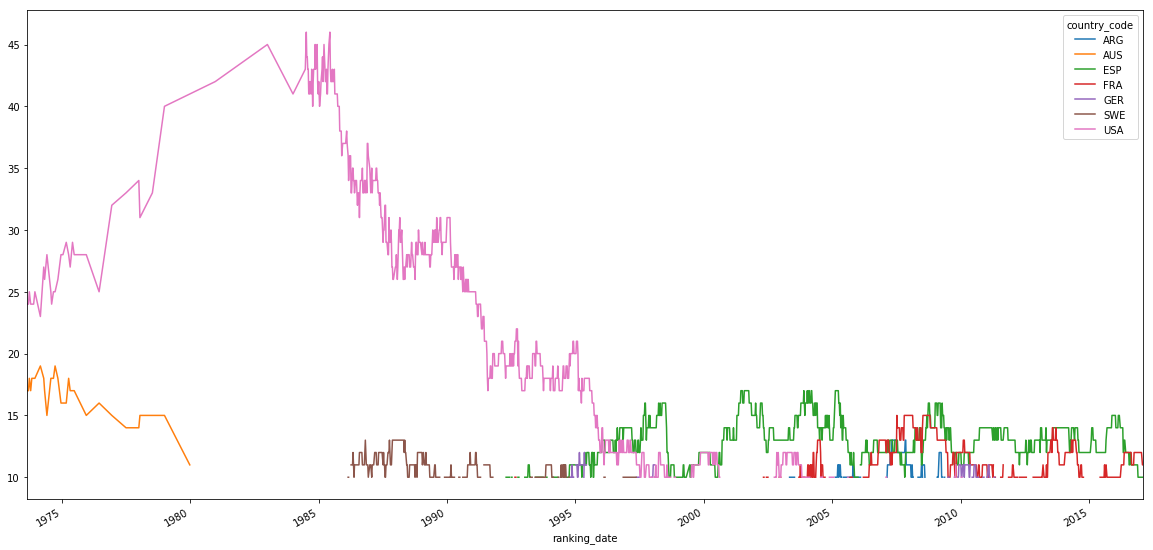

In [134]:
# transform to dataframe

pivoted = pd.pivot_table(aggregate_least_10, values='0', columns='country_code', index="ranking_date")
pivoted.plot(figsize=(20,10))

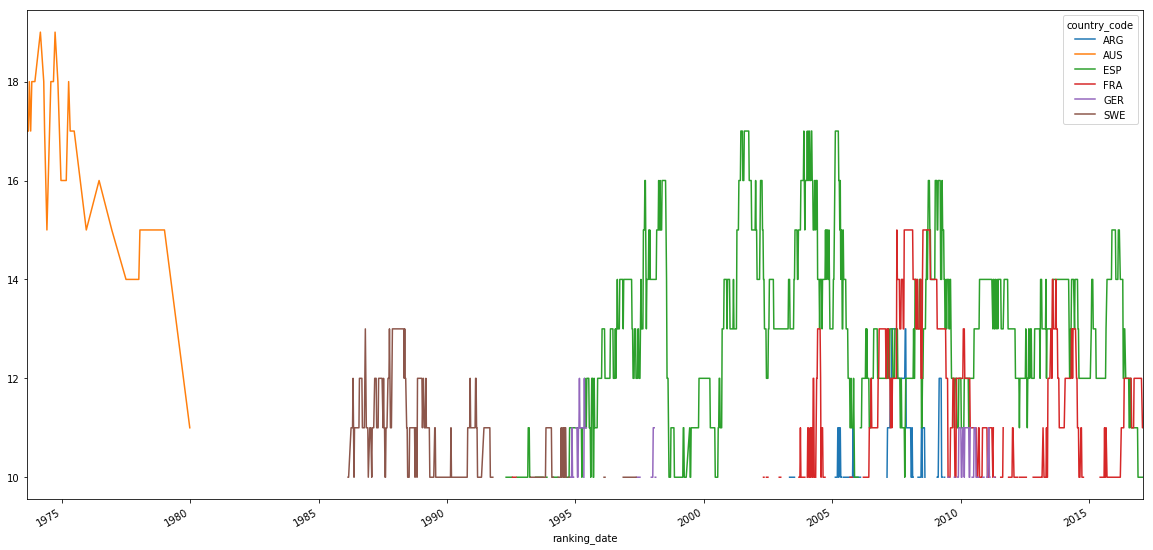

In [194]:
# we can't see much from that figure

aggregate_no_usa = aggregate[(aggregate["country_code"] != "USA") & (aggregate["0"] > 9)]
pivoted = pd.pivot_table(aggregate_no_usa, values='0', columns='country_code', index="ranking_date")
pivoted.plot(figsize=(20,10))

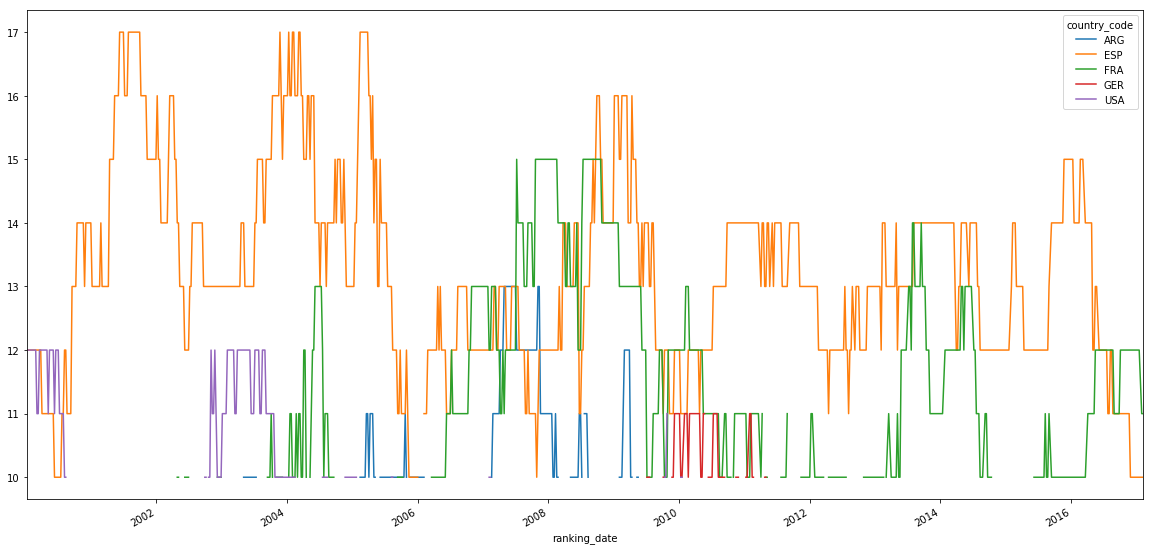

In [147]:
aggregate_after_2000 = aggregate[(aggregate["ranking_date"] > "2000-01-01" ) & (aggregate["0"] > 9)]
pivoted = pd.pivot_table(aggregate_after_2000, values='0', columns='country_code', index="ranking_date")
pivoted.plot(figsize=(20,10))

In [172]:
# let's see how it fairs by continent

import json

with open('iso3.json') as data_file:    
    countries = json.load(data_file)
with open('continent.json') as data_file:    
    continents = json.load(data_file)

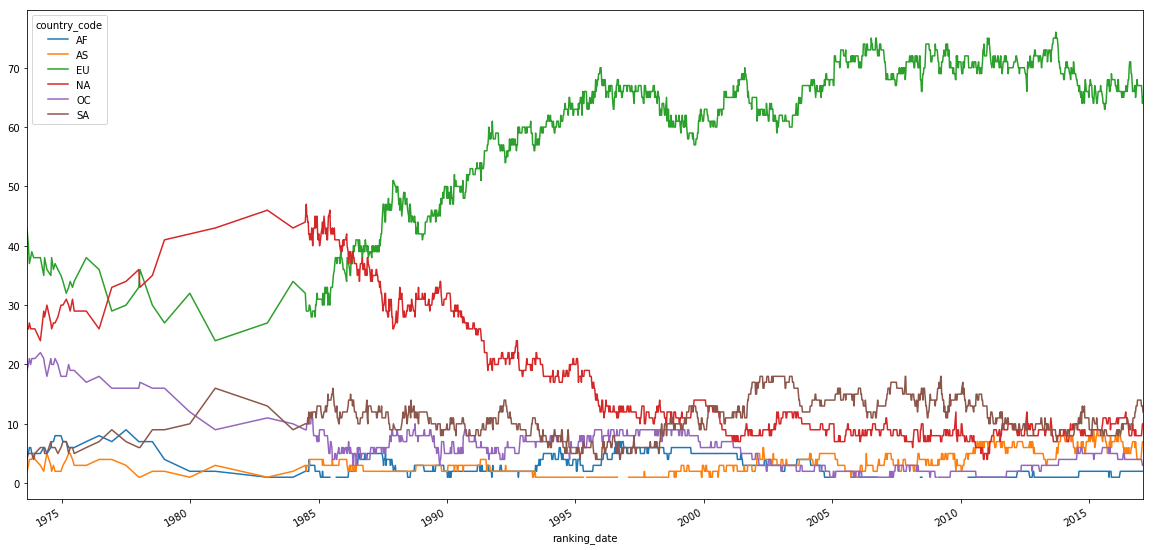

In [250]:
ioc_countries = {}
for country in countries:
    if country["ioc"]:
        ioc_countries[country["ioc"]] = country["alpha2"]
ioc_countries["YUG"] = "MK"
aggregate_continents = aggregate.copy()
ioc_countries
aggregate_continents
aggregate_continents["country_code"] = aggregate_continents["country_code"].apply(lambda row: continents[ioc_countries[row]])

aggregate_continents = aggregate_continents[["ranking_date", "country_code", "0"]].groupby(["ranking_date", "country_code"]).sum()
aggregate_continents = pd.DataFrame(aggregate_continents.to_records()) # transform the series to df
pivoted = pd.pivot_table(aggregate_continents, values='0', columns='country_code', index="ranking_date")
pivoted.plot(figsize=(20,10))